In [1]:
###########################################################################
# An example of an object classification/categorization system
# using a CNN on color images from the dataset CIFAR-10.
# Adapted from the PyTorch Tutorials, "Training a Classifier"
###########################################################################

import torch, torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of range [0, 1].
# Transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Classes of images
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Read in the training & testing data
iterBatchSize = 5
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=iterBatchSize, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=iterBatchSize, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


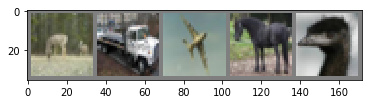

deer, truck, plane, horse, bird


In [2]:
# What does the training data look like?
import matplotlib.pyplot as plt
import numpy as np
# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow( np.transpose(img.numpy(), (1, 2, 0)) )
# Let's look at some example training images
dataiter = iter(trainloader) # For training images
testdataiter = iter(testloader) # For testing images (used later)
images, labels = dataiter.next() # Ask the iterator for some images
# Show images and labels
imshow(torchvision.utils.make_grid(images))
plt.show()
print(', '.join('%s' % classes[labels[j]] for j in range(iterBatchSize)))

In [3]:
# Now we can define our model

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Define a small CNN that processes 3-channel images
class Net(nn.Module):
    # Initialize our layers, i.e. the set of trainable parameters
    def __init__(self):
        super(Net, self).__init__()
        # A convolutional layer
        # The number of input channels is 3 this time (rgb)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # A max pooling layer (will be reused for each conv layer)
        self.pool = nn.MaxPool2d(2, 2)
        # Another convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Three sets of fully connected (linear) layers 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # For each conv layer: conv -> relu -> pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape from higher dimensional tensor to a vector for the FC layers
        x = x.view(-1, 16 * 5 * 5)
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_saved_name = 'cifar10-net.model'
net = Net()

In [4]:
# Look at the weights and network structure
print(net.state_dict().keys())
print("Conv1:",net.conv1.weight.size())
print("Conv2:",net.conv2.weight.size())
print(net.conv1.weight[3,:,:,:])
print(net.conv2.weight.size())
print(net.conv2.weight[3,:,:,:])

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
Conv1: torch.Size([6, 3, 5, 5])
Conv2: torch.Size([16, 6, 5, 5])
Variable containing:
(0 ,.,.) = 
  0.0006  0.0618  0.0449 -0.0065 -0.0367
  0.0199  0.0994 -0.0184 -0.0548  0.0764
 -0.0111 -0.1152  0.0973 -0.0977  0.1135
  0.0726 -0.0928  0.1021 -0.0513  0.1106
 -0.1086  0.0913  0.0039  0.1137 -0.0802

(1 ,.,.) = 
 -0.0980  0.0820  0.0805  0.0162 -0.0477
 -0.0786 -0.0734  0.0144  0.0678 -0.0222
 -0.0115  0.0804  0.1037  0.1008 -0.0568
  0.0551  0.0175 -0.0678  0.0239 -0.0885
  0.0254 -0.0368 -0.0626 -0.0053  0.0016

(2 ,.,.) = 
  0.0434  0.0238 -0.0212 -0.0380  0.1020
 -0.0742 -0.0042 -0.0158 -0.0870 -0.0769
 -0.0592 -0.0213 -0.0796 -0.0744  0.0157
  0.0043 -0.0164 -0.0829  0.1055 -0.0384
  0.0092  0.0629  0.0580  0.0517 -0.1028
[torch.FloatTensor of size 3x5x5]

torch.Size([16, 6, 5, 5])
Variable containing:
(0 ,.,.) = 
1.00000e-02 *
  

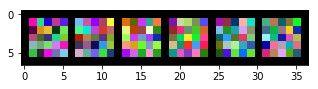

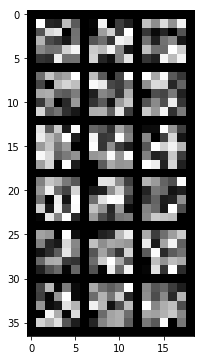

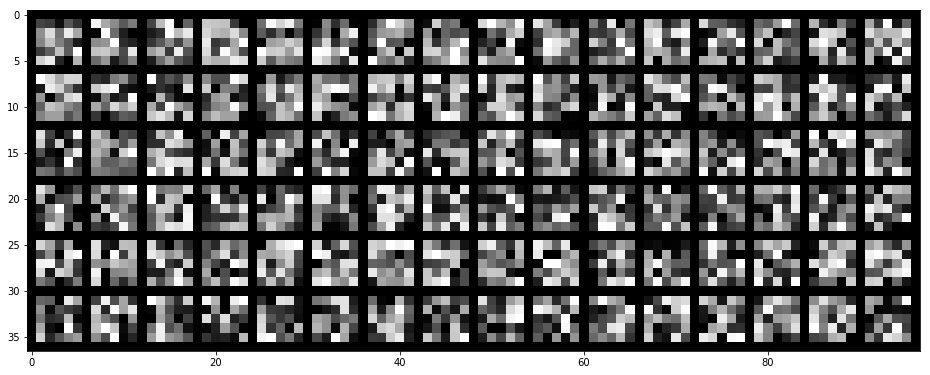

In [5]:
from torchvision import utils
# Define a method to help visualize the convolutional kernels
# From: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb
def vistensor(tensor, ch=0, allkernels=False, ncol=8, padding=1): 
    ''' @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min( (tensor.shape[0]//ncol + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=ncol, normalize=True, padding=padding, scale_each=True)
    plt.figure( figsize=(ncol,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()

# Visualize the parameters of tensors before training (just noise)
vistensor(net.conv1.weight.data) # Can view the first conv layer's kernels as being RGB
# Or treat each of the 6 units as having 3 greyscale filters
vistensor(net.conv1.weight.data, allkernels=True, ncol=3) 
# The second layer's filters
vistensor(net.conv2.weight.data, allkernels=True, ncol=16) # 

In [6]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
import os
# Load the model from disk if it already exists
if os.path.exists(model_saved_name):
    net.load_state_dict(torch.load(model_saved_name))
    print('Loaded model')
# Otherwise train it from scratch
else:
    for epoch in range(3):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training')

[1,  2000] loss: 2.194
[1,  4000] loss: 1.833
[1,  6000] loss: 1.655
[1,  8000] loss: 1.564
[1, 10000] loss: 1.490
[2,  2000] loss: 1.437
[2,  4000] loss: 1.377
[2,  6000] loss: 1.364
[2,  8000] loss: 1.313
[2, 10000] loss: 1.271
[3,  2000] loss: 1.214
[3,  4000] loss: 1.208
[3,  6000] loss: 1.218
[3,  8000] loss: 1.189
[3, 10000] loss: 1.172
Finished Training


In [8]:
# Save it if a model file is not already present
if not os.path.exists(model_saved_name):
    torch.save(net.state_dict(), model_saved_name)

GroundTruth:    cat  ship  ship plane  frog
Predicted:     ship  ship   car plane  frog


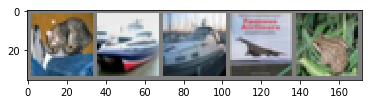

GroundTruth:   frog   car  frog   cat   car
Predicted:     frog  bird  frog   cat   car


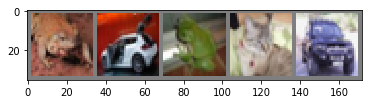

GroundTruth:  plane truck   dog horse truck
Predicted:    plane truck  frog horse truck


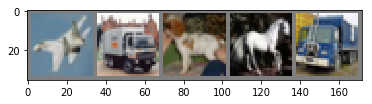

In [9]:
# Let's see what the network learned on some example images
for _ in range(3):
    images, labels = testdataiter.next()
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(iterBatchSize)))
    # Output predicted by our net
    outputs = net(Variable(images))
    # Predicted class = index of max probability (treating output as probability)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]] for j in range(iterBatchSize)))
    plt.show()

In [10]:
# Overall accuracy on the test set
correct, total = 0, 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 59 %


In [11]:
# What are the accuracies per class?
nClasses = 10
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(iterBatchSize):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(nClasses):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 73 %
Accuracy of  bird : 42 %
Accuracy of   cat : 26 %
Accuracy of  deer : 62 %
Accuracy of   dog : 48 %
Accuracy of  frog : 63 %
Accuracy of horse : 72 %
Accuracy of  ship : 77 %
Accuracy of truck : 65 %


In [12]:
# Compute the confusion matrix
from torchnet import meter
confusion_matrix = meter.ConfusionMeter(nClasses) 
for ii, data in enumerate(testloader):
    input, label = data
    val_input = Variable(input, volatile=True) #.cuda()
    val_label = Variable(label.type(torch.LongTensor), volatile=True) #.cuda()
    score = net(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
# Display the confusion matrix
# Perhaps there are some patterns in which ones the classifier gets wrong
a = confusion_matrix.conf
fig = plt.figure() 
ax = fig.add_subplot(1,1,1)
plt.imshow(a, cmap='hot', interpolation='nearest', aspect='auto')
plt.xticks(list(range(nClasses)))
plt.yticks(list(range(nClasses)))
ax.set_yticklabels(classes)
ax.set_xticklabels(classes)
plt.show() # Rows are ground-truth, cols are predictions

ModuleNotFoundError: No module named 'torchnet'

In [ ]:
# Recall the kernels were gaussian random noise at the start
vistensor(net.conv1.weight.data)
vistensor(net.conv1.weight.data, allkernels=True, ncol=3)
vistensor(net.conv2.weight.data,allkernels=True,ncol=16)

In [ ]:
# For more visualizations, see: Visualizing and Understanding Convolutional Networks, Zeiler and Fergus, 2014